# Diffusion Transformers (DiT): From Class to Text Conditioning

**Paper**: [Scalable Diffusion Models with Transformers](https://arxiv.org/abs/2212.09748)

**Authors**: William Peebles, Saining Xie (Meta AI / UC Berkeley, 2023)

---

## 🎯 Complete Learning Journey

This notebook explores **DiT evolution**:

### Learning Path

1. **Part 1-2**: Why Transformer? + Architecture
2. **Part 3**: Class-conditional DiT (Original)
3. **Part 4**: Text-conditional DiT (+ CLIP)
4. **Part 5**: Comparison & Analysis

### What You'll Build

✅ Class-conditional DiT (original paper)

✅ Text-conditional DiT (DiT + CLIP)

✅ Complete understanding: UNet → Transformer

| Component | SD (UNet) | DiT (Original) | DiT + CLIP |
|-----------|-----------|----------------|------------|
| Core | CNN | Transformer | Transformer |
| Conditioning | Cross-Attn | AdaLN only | AdaLN + Cross-Attn |
| Text | CLIP | ❌ | ✅ CLIP |
| Params | 6 AdaLN | 6 AdaLN | **9 AdaLN** |

---

## 🔑 Key Innovation: UNet → Transformer

### The Problem with UNet

Stable Diffusion uses **UNet**:
- Conv-based (inductive bias for images)
- Complex architecture (encoder/decoder, skip connections)
- Hard to scale (architecture design matters)

### DiT Solution

Use **Vision Transformer** instead:
- Pure attention (minimal inductive bias)
- Uniform architecture (stack identical blocks)
- **Easy to scale** (more layers = better model)

**Result**:
- 🚀 Better scalability
- 🎨 Simpler implementation
- 📈 Competitive performance

---

## 📊 Comparison: UNet vs DiT

| Aspect | UNet (SD 1.5/2.1) | DiT (Meta) |
|--------|------------------|------------|
| **Architecture** | CNN + Attention | **Pure Transformer** |
| **Spatial Processing** | Conv with stride | **Patchify** |
| **Blocks** | Varied (Down/Up) | **Uniform** |
| **Complexity** | High | **Low** |
| **Scalability** | Manual design | **Automatic** |
| **ImageNet FID** | 2.3 (ADM) | **2.27 (DiT-XL)** |

DiT achieves **same quality** with **simpler code**!

---

# Part 1: DiT Architecture - Foundation

## 🎯 Core Idea

Replace UNet's CNN with **Vision Transformer**:

```
UNet Pipeline:
x → [Conv Down] → [Bottleneck] → [Conv Up] → output

DiT Pipeline:
x → [Patchify] → [Transformer] → [Unpatchify] → output
```

### Three Steps

**1. Patchify**:
- Input: `[B, C, H, W]`
- Output: `[B, N, D]` where N = (H/p) × (W/p), D = p²×C
- Example: `[B, 4, 32, 32]` → `[B, 256, 64]` (patch_size=2)

**2. Transformer Blocks**:
- Self-attention across patches
- Modulated by timestep + condition
- NO spatial convolution!

**3. Unpatchify**:
- Reverse: `[B, N, D]` → `[B, C, H, W]`

---

## 📐 DiT Block (Original)

**Core component**: Adaptive Layer Norm (AdaLN)

```python
# Instead of fixed LayerNorm:
x = LayerNorm(x)

# Use AdaLN (modulated by condition):
shift, scale = adaln_mlp(condition)
x = LayerNorm(x) * (1 + scale) + shift
```

**6 AdaLN parameters per block**:
1. Self-Attention: `shift₁, scale₁, gate₁`
2. MLP: `shift₂, scale₂, gate₂`

**Pseudocode**:
```python
def dit_block(x, condition):
    # Get 6 modulation params
    s1, sc1, g1, s2, sc2, g2 = adaln_mlp(condition).chunk(6)
    
    # Modulated Self-Attention
    h = layer_norm(x) * (1 + sc1) + s1
    h = self_attention(h)
    x = x + g1 * h
    
    # Modulated MLP
    h = layer_norm(x) * (1 + sc2) + s2
    h = mlp(h)
    x = x + g2 * h
    
    return x
```

---

## 🔄 Conditioning

**Original DiT** (Class-conditional):
```python
t_emb = timestep_embedding(t)    # [B, D]
y_emb = label_embedding(class)   # [B, D]
c = t_emb + y_emb                # [B, D]
adaln_params = mlp(c)            # [B, 6*D]
```

**No cross-attention!** Everything through AdaLN.

Let's implement it!

## Step 1: Setup

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import math
from diffusers import AutoencoderKL, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import sys
sys.path.append('..')
from utils.visualization import plot_images

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Step 2: Load VAE and Scheduler

In [3]:
print("📥 Loading VAE and Scheduler...\n")

# VAE
vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-mse",
    torch_dtype=torch.float32
).to(device)
vae.eval()
for param in vae.parameters():
    param.requires_grad = False

# DDPM Scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="scaled_linear",
    prediction_type="epsilon"
)

print("✅ VAE and Scheduler loaded")
print("   Note: DiT is class-conditional (no text encoder!)")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


📥 Loading VAE and Scheduler...

✅ VAE and Scheduler loaded
   Note: DiT is class-conditional (no text encoder!)


## Step 3: DiT Architecture (Original from Paper)

### Core Components:
1. **Patchify**: Image → Patch sequence
2. **DiT Block**: Adaptive Layer Norm + Self-Attention (NO Cross-Attention!)
3. **Unpatchify**: Patch sequence → Image

### DiT:
- Class embedding (label → vector)
- 6 AdaLN params: (shift, scale, gate) × 2 (self-attn + MLP)
- **NO Cross-Attention!**

In [4]:
class TimestepEmbedder(nn.Module):
    """Timestep embedding with sinusoidal positional encoding"""
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class LabelEmbedder(nn.Module):
    """Class label embedding"""
    def __init__(self, num_classes, hidden_size):
        super().__init__()
        self.embedding_table = nn.Embedding(num_classes, hidden_size)

    def forward(self, labels):
        return self.embedding_table(labels)


class DiTBlock(nn.Module):
    """
    Original DiT Block (Figure 3 from paper)
    - NO Cross-Attention!
    - Only Self-Attention + MLP
    - 6 AdaLN parameters: (shift, scale, gate) for self-attn and MLP
    """
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = nn.MultiheadAttention(hidden_size, num_heads, batch_first=True)
        
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, mlp_hidden_dim),
            nn.GELU(),
            nn.Linear(mlp_hidden_dim, hidden_size),
        )
        
        # AdaLN modulation: 6 parameters (original DiT)
        # (shift, scale, gate) for self-attn + (shift, scale, gate) for mlp
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 6 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        """
        x: [B, N, D] latent patches
        c: [B, D] conditioning (timestep + class)
        """
        # AdaLN modulation: 6 parameters
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = \
            self.adaLN_modulation(c).chunk(6, dim=1)
        
        # Self-Attention with AdaLN
        x_norm = self.norm1(x) * (1 + scale_msa.unsqueeze(1)) + shift_msa.unsqueeze(1)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + gate_msa.unsqueeze(1) * attn_out
        
        # MLP with AdaLN
        x_norm = self.norm2(x) * (1 + scale_mlp.unsqueeze(1)) + shift_mlp.unsqueeze(1)
        x = x + gate_mlp.unsqueeze(1) * self.mlp(x_norm)
        
        return x


class DiT(nn.Module):
    """
    Original DiT from paper (arXiv:2212.09748)
    Class-conditional, NO text encoder
    """
    def __init__(
        self,
        input_size=32,      # Latent size
        patch_size=2,       # Patch size
        in_channels=4,      # Latent channels
        hidden_size=768,    # Transformer hidden size
        depth=12,           # Number of DiT blocks
        num_heads=12,       # Attention heads
        mlp_ratio=4.0,
        num_classes=10,     # MNIST: 10 classes
    ):
        super().__init__()
        self.input_size = input_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.out_channels = in_channels
        self.num_heads = num_heads

        # Patch embedding
        self.x_embedder = nn.Linear(patch_size * patch_size * in_channels, hidden_size)
        
        # Timestep embedding
        self.t_embedder = TimestepEmbedder(hidden_size)
        
        # Class label embedding
        self.y_embedder = LabelEmbedder(num_classes, hidden_size)
        
        # Positional embedding
        num_patches = (input_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size))
        
        # DiT blocks
        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, mlp_ratio)
            for _ in range(depth)
        ])
        
        # Final layer
        self.final_layer = nn.Sequential(
            nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6),
            nn.Linear(hidden_size, patch_size * patch_size * self.out_channels),
        )
        
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        # Initialize pos_embed
        nn.init.normal_(self.pos_embed, std=0.02)

    def unpatchify(self, x):
        """
        x: [B, N, patch_size^2 * C]
        return: [B, C, H, W]
        """
        c = self.out_channels
        p = self.patch_size
        h = w = self.input_size // p

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, w * p))
        return imgs

    def patchify(self, x):
        """
        x: [B, C, H, W]
        return: [B, N, patch_size^2 * C]
        """
        B, C, H, W = x.shape
        p = self.patch_size
        h, w = H // p, W // p
        x = x.reshape(B, C, h, p, w, p)
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(B, h * w, p * p * C)
        return x

    def forward(self, x, t, y):
        """
        x: [B, 4, 32, 32] latent
        t: [B] timesteps
        y: [B] class labels
        """
        # Patchify
        x = self.patchify(x)  # [B, N, patch_size^2 * 4]
        x = self.x_embedder(x) + self.pos_embed  # [B, N, hidden_size]
        
        # Timestep + Class embedding
        t_emb = self.t_embedder(t)  # [B, hidden_size]
        y_emb = self.y_embedder(y)  # [B, hidden_size]
        c = t_emb + y_emb  # [B, hidden_size] - conditioning
        
        # DiT blocks
        for block in self.blocks:
            x = block(x, c)
        
        # Final layer
        x = self.final_layer(x)  # [B, N, patch_size^2 * 4]
        
        # Unpatchify
        x = self.unpatchify(x)  # [B, 4, 32, 32]
        
        return x


# Create DiT model
dit = DiT(
    input_size=32,
    patch_size=2,
    in_channels=4,
    hidden_size=384,  # Smaller for MNIST
    depth=8,
    num_heads=6,
    num_classes=10,  # MNIST digits 0-9
).to(device)

num_params = sum(p.numel() for p in dit.parameters())
print(f"✅ DiT created: {num_params:,} params ({num_params/1e6:.1f}M)")
print(f"   Input: [B, 4, 32, 32]")
print(f"   Patches: {(32//2)**2} patches of size 2×2")
print(f"   Hidden size: 384")
print(f"   Depth: 8 blocks")
print(f"   Conditioning: Class labels (0-9)")
print(f"   AdaLN params: 6 (NO Cross-Attention!)")

✅ DiT created: 21,641,104 params (21.6M)
   Input: [B, 4, 32, 32]
   Patches: 256 patches of size 2×2
   Hidden size: 384
   Depth: 8 blocks
   Conditioning: Class labels (0-9)
   AdaLN params: 6 (NO Cross-Attention!)


## Step 4: Prepare Dataset

In [5]:
transform_vae = transforms.Compose([
    transforms.Resize(256),
    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform_vae
)

print("📦 Pre-encoding MNIST dataset with VAE...\n")

latents_list = []
labels_list = []

temp_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

with torch.no_grad():
    for images, labels in tqdm(temp_loader, desc="Encoding"):
        images = images.to(device)
        
        # Encode images
        latent_dist = vae.encode(images).latent_dist
        latents = latent_dist.sample() * 0.18215
        
        latents_list.append(latents.cpu())
        labels_list.append(labels)

all_latents = torch.cat(latents_list, dim=0)
all_labels = torch.cat(labels_list, dim=0)

class LatentLabelDataset(torch.utils.data.Dataset):
    def __init__(self, latents, labels):
        self.latents = latents
        self.labels = labels
    
    def __len__(self):
        return len(self.latents)
    
    def __getitem__(self, idx):
        return self.latents[idx], self.labels[idx]

latent_dataset = LatentLabelDataset(all_latents, all_labels)
train_loader = DataLoader(latent_dataset, batch_size=128, shuffle=True, num_workers=4, persistent_workers=True, pin_memory=True)

print(f"\n✅ Dataset ready: {len(all_latents)} samples")
print(f"   Latent shape: {all_latents[0].shape}")
print(f"   Labels: {all_labels[:10].tolist()}")

📦 Pre-encoding MNIST dataset with VAE...



Encoding:   0%|          | 0/938 [00:00<?, ?it/s]


✅ Dataset ready: 60000 samples
   Latent shape: torch.Size([4, 32, 32])
   Labels: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


## Step 5: Training DiT (Class-conditional)

In [5]:
num_epochs = 10
learning_rate = 1e-4

optimizer = torch.optim.AdamW(dit.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

print(f"🎓 Training DiT (Class-conditional)...")
print(f"   Epochs: {num_epochs}")
print(f"   Architecture: Original DiT (NO Cross-Attention!)\n")

losses = []
dit.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for latents_batch, labels_batch in progress_bar:
        latents_batch = latents_batch.to(device)
        labels_batch = labels_batch.to(device)
        batch_size = latents_batch.shape[0]
        
        # Add noise
        noise = torch.randn_like(latents_batch)
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (batch_size,), device=device
        ).long()
        
        noisy_latents = noise_scheduler.add_noise(latents_batch, noise, timesteps)
        
        # Predict noise with DiT (class-conditional)
        noise_pred = dit(noisy_latents, timesteps, labels_batch)
        
        loss = criterion(noise_pred, noise)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(dit.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        losses.append(loss.item())
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

print("\n✅ DiT training complete!")

# Save
import os
os.makedirs('../checkpoints', exist_ok=True)
torch.save({'dit': dit.state_dict()}, '../checkpoints/dit_mnist.pt')
print("💾 Saved to: ../checkpoints/dit_mnist.pt")

🎓 Training DiT (Class-conditional)...
   Epochs: 10
   Architecture: Original DiT (NO Cross-Attention!)



Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.2378


Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.1334


Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 | Loss: 0.1177


Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 | Loss: 0.1103


Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 | Loss: 0.1050


Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6 | Loss: 0.1011


Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7 | Loss: 0.0978


Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.0948


Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.0922


Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.0893

✅ DiT training complete!
💾 Saved to: ../checkpoints/dit_mnist.pt


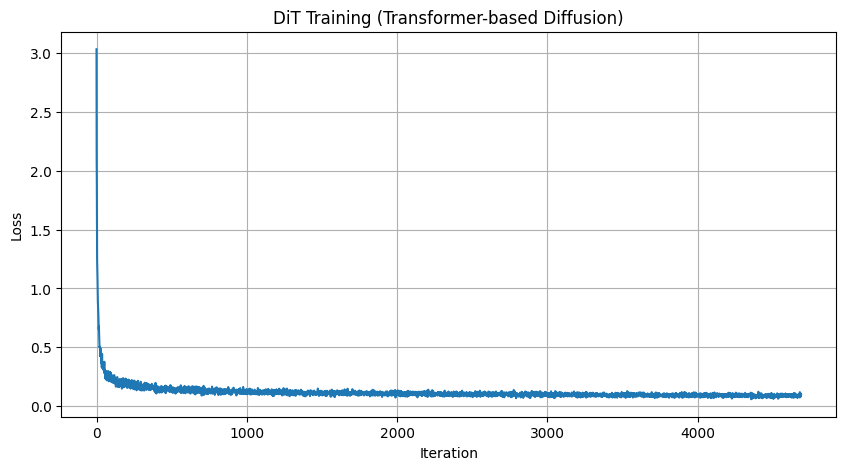

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('DiT Training (Transformer-based Diffusion)')
plt.grid(True)
plt.savefig('../outputs/loss_dit.png', dpi=150, bbox_inches='tight')
plt.show()


🎨 Generating samples with trained DiT (Class-conditional)...

✅ Loaded class-conditional DiT: 21,641,104 params (21.6M)



Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

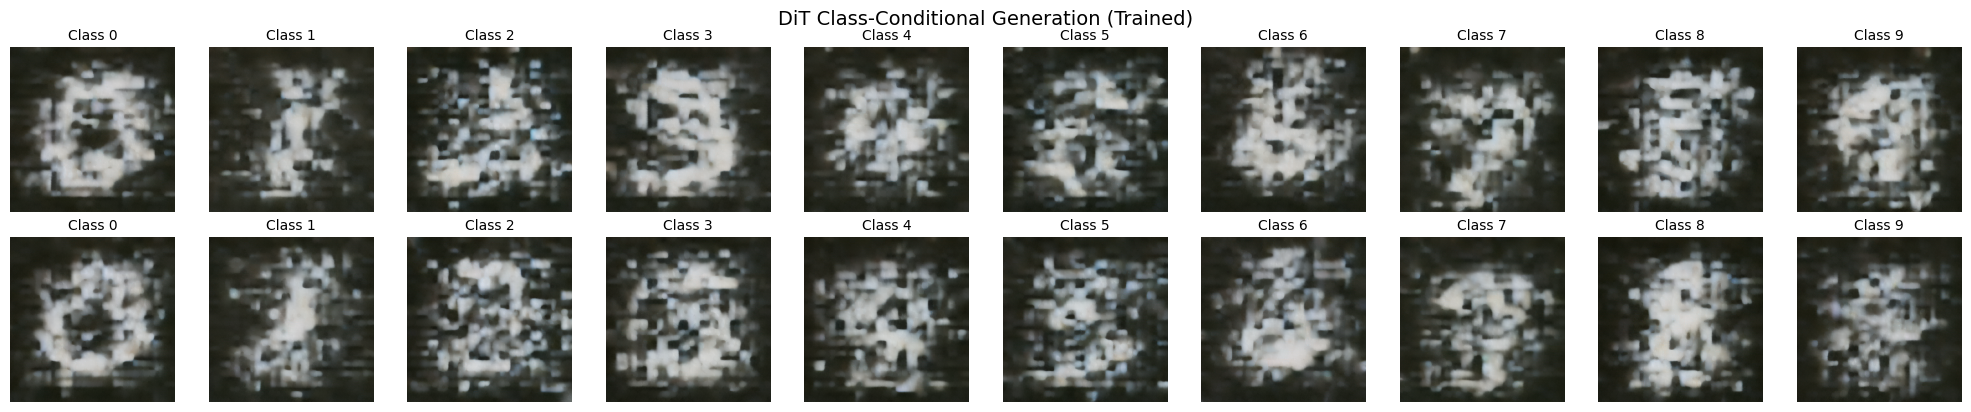


✅ Generated 20 images
   Classes: 0-9 (2 samples each)
   Resolution: 256×256
   Architecture: Original DiT (NO Cross-Attention)


In [7]:
# Visualization: Generate samples with trained DiT (Class-conditional)
print("\n🎨 Generating samples with trained DiT (Class-conditional)...\n")

# Load the original class-conditional DiT model
dit_class = DiT(
    input_size=32,
    patch_size=2,
    in_channels=4,
    hidden_size=384,
    depth=8,
    num_heads=6,
    num_classes=10,
).to(device)

# Load checkpoint
checkpoint = torch.load('../checkpoints/dit_mnist.pt', map_location=device)
dit_class.load_state_dict(checkpoint['dit'])
dit_class.eval()

num_params = sum(p.numel() for p in dit_class.parameters())
print(f"✅ Loaded class-conditional DiT: {num_params:,} params ({num_params/1e6:.1f}M)\n")

@torch.no_grad()
def sample_dit_class(dit, vae, scheduler, class_labels, num_inference_steps=50):
    """
    Sample from class-conditional DiT

    Args:
        dit: Trained DiT model
        vae: VAE decoder
        scheduler: DDPM scheduler
        class_labels: [B] class labels (0-9)
        num_inference_steps: Number of sampling steps
    """
    dit.eval()
    batch_size = len(class_labels)

    # Start from random noise
    latents = torch.randn(batch_size, 4, 32, 32).to(device)

    # Set timesteps
    scheduler.set_timesteps(num_inference_steps)

    # Denoising loop
    for t in tqdm(scheduler.timesteps, desc="Sampling"):
        # Predict noise with DiT
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
        noise_pred = dit(latents, t_batch, class_labels)

        # Denoise
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents
    latents = latents / 0.18215
    images = vae.decode(latents).sample

    # Normalize to [0, 1]
    images = (images + 1) / 2
    images = torch.clamp(images, 0, 1)

    return images

# Generate one sample per class (0-9), repeated twice
class_labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9] * 2).to(device)

samples = sample_dit_class(dit_class, vae, noise_scheduler, class_labels, num_inference_steps=50)

# Visualize
titles = [f'Class {label.item()}' for label in class_labels]
plot_images(samples, titles=titles, nrows=2, ncols=10, figsize=(20, 4))
plt.suptitle('DiT Class-Conditional Generation (Trained)', fontsize=14, y=1.02)
plt.savefig('../outputs/dit_class_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Generated {len(samples)} images")
print(f"   Classes: 0-9 (2 samples each)")
print(f"   Resolution: 256×256")
print(f"   Architecture: Original DiT (NO Cross-Attention)")


---

# Part 2: DiT + CLIP (Text-Conditional)

Now we add **text conditioning** with CLIP!

## 🔄 What Changes?

### Original DiT (Class)
```python
# 6 AdaLN params (Self-Attn + MLP)
c = t_emb + class_emb  # [B, D]
x = dit_block(x, c)    # Only AdaLN
```

### DiT + CLIP (Text)
```python
# 9 AdaLN params (Self-Attn + Cross-Attn + MLP)
text_emb = clip_encoder(text)  # [B, 77, 512]
x = dit_block(x, t_emb, text_emb)  # AdaLN + Cross-Attn
```

**Key Addition**: Cross-Attention!

---

## 📐 Modified DiT Block

```python
def dit_block_with_cross_attn(x, t_emb, text_emb):
    # Get 9 modulation params (3 more!)
    params = adaln_mlp(t_emb).chunk(9)
    s1, sc1, g1, s2, sc2, s3, sc3, g3, _ = params
    
    # 1. Self-Attention
    h = layer_norm(x) * (1 + sc1) + s1
    x = x + g1 * self_attention(h)
    
    # 2. Cross-Attention (NEW!)
    h = layer_norm(x) * (1 + sc2) + s2
    x = x + cross_attention(h, text_emb)  # Query from x, K/V from text
    
    # 3. MLP
    h = layer_norm(x) * (1 + sc3) + s3
    x = x + g3 * mlp(h)
    
    return x
```

Let's implement!

In [6]:
print("📥 Loading pretrained components...\n")

# VAE
vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-mse",
    torch_dtype=torch.float32
).to(device)
vae.eval()
for param in vae.parameters():
    param.requires_grad = False

# CLIP Text Encoder
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
text_encoder.eval()
for param in text_encoder.parameters():
    param.requires_grad = False

# DDPM Scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="scaled_linear",
    prediction_type="epsilon"
)

print("✅ VAE, CLIP, Scheduler loaded")
print("   DiT + CLIP = Text-conditional DiT!")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


📥 Loading pretrained components...

✅ VAE, CLIP, Scheduler loaded
   DiT + CLIP = Text-conditional DiT!


## Step 3: DiT + CLIP Architecture


In [7]:
import torch
import torch.nn as nn
import math


class TimestepEmbedder(nn.Module):
    """Timestep embedding with sinusoidal positional encoding"""
    
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.frequency_embedding_size = frequency_embedding_size
    
    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        
        return embedding
    
    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class DiTBlockCrossAttn(nn.Module):
    """
    DiT Block with Cross-Attention (DiT + CLIP)
    9 AdaLN parameters:
    - Self-Attention: shift, scale, gate (3)
    - Cross-Attention: shift, scale (2)
    - MLP: shift, scale, gate (3)
    """
    
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = nn.MultiheadAttention(hidden_size, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.cross_attn = nn.MultiheadAttention(hidden_size, num_heads, batch_first=True)
        self.norm3 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, mlp_hidden_dim),
            nn.GELU(),
            nn.Linear(mlp_hidden_dim, hidden_size),
        )
        
        # AdaLN modulation: 9 parameters
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 9 * hidden_size, bias=True)
        )
    
    def forward(self, x, c, text_emb):
        """
        x: [B, N, D] latent patches
        c: [B, D] timestep embedding
        text_emb: [B, L, D] CLIP embeddings
        """
        # AdaLN modulation: 9 parameters
        params = self.adaLN_modulation(c).chunk(9, dim=1)
        shift_msa, scale_msa, gate_msa = params[0], params[1], params[2]
        shift_mca, scale_mca = params[3], params[4]
        shift_mlp, scale_mlp, gate_mlp = params[5], params[6], params[7]
        
        # Self-Attention with AdaLN
        x_norm = self.norm1(x) * (1 + scale_msa.unsqueeze(1)) + shift_msa.unsqueeze(1)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + gate_msa.unsqueeze(1) * attn_out
        
        # Cross-Attention with text and AdaLN modulation
        x_norm2 = self.norm2(x) * (1 + scale_mca.unsqueeze(1)) + shift_mca.unsqueeze(1)
        cross_attn_out, _ = self.cross_attn(x_norm2, text_emb, text_emb)
        x = x + cross_attn_out
        
        # MLP with AdaLN
        x_norm3 = self.norm3(x) * (1 + scale_mlp.unsqueeze(1)) + shift_mlp.unsqueeze(1)
        x = x + gate_mlp.unsqueeze(1) * self.mlp(x_norm3)
        
        return x


class DiTCLIP(nn.Module):
    """DiT + CLIP = Text-conditional DiT"""
    
    def __init__(
        self,
        input_size=32,
        patch_size=2,
        in_channels=4,
        hidden_size=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        cross_attention_dim=512,  # CLIP dim
    ):
        super().__init__()
        self.input_size = input_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.out_channels = in_channels
        
        # Patch embedding
        self.x_embedder = nn.Linear(patch_size * patch_size * in_channels, hidden_size)
        
        # Timestep embedding
        self.t_embedder = TimestepEmbedder(hidden_size)
        
        # Positional embedding
        num_patches = (input_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size))
        
        # Text projection (CLIP 512 → hidden_size)
        self.text_proj = nn.Linear(cross_attention_dim, hidden_size)
        
        # DiT blocks with Cross-Attention
        self.blocks = nn.ModuleList([
            DiTBlockCrossAttn(hidden_size, num_heads, mlp_ratio)
            for _ in range(depth)
        ])
        
        # Final layer
        self.final_layer = nn.Sequential(
            nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6),
            nn.Linear(hidden_size, patch_size * patch_size * self.out_channels),
        )
        
        self.initialize_weights()
    
    def initialize_weights(self):
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)
        nn.init.normal_(self.pos_embed, std=0.02)
    
    def unpatchify(self, x):
        c = self.out_channels
        p = self.patch_size
        h = w = self.input_size // p
        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, w * p))
        return imgs
    
    def patchify(self, x):
        B, C, H, W = x.shape
        p = self.patch_size
        h, w = H // p, W // p
        x = x.reshape(B, C, h, p, w, p)
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(B, h * w, p * p * C)
        return x
    
    def forward(self, x, t, text_emb):
        """
        x: [B, 4, 32, 32] latent
        t: [B] timesteps
        text_emb: [B, 77, 512] CLIP embeddings
        """
        # Patchify
        x = self.patchify(x)
        x = self.x_embedder(x) + self.pos_embed
        
        # Timestep embedding
        t_emb = self.t_embedder(t)
        
        # Project text embeddings
        text_emb = self.text_proj(text_emb)
        
        # DiT blocks
        for block in self.blocks:
            x = block(x, t_emb, text_emb)
        
        # Final layer
        x = self.final_layer(x)
        
        # Unpatchify
        x = self.unpatchify(x)
        
        return x


# Create DiT + CLIP model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dit = DiTCLIP(
    input_size=32,
    patch_size=2,
    in_channels=4,
    hidden_size=384,
    depth=8,
    num_heads=6,
    cross_attention_dim=512,
).to(device)

num_params = sum(p.numel() for p in dit.parameters())
print(f"✅ DiT + CLIP created: {num_params:,} params ({num_params/1e6:.1f}M)")
print(f"   Text encoder: CLIP (512-dim)")
print(f"   Architecture: DiT + Cross-Attention")
print(f"   AdaLN params: 9 (Self + Cross + MLP)")

✅ DiT + CLIP created: 30,113,296 params (30.1M)
   Text encoder: CLIP (512-dim)
   Architecture: DiT + Cross-Attention
   AdaLN params: 9 (Self + Cross + MLP)


## Step 4: Prepare Dataset

In [8]:
# transforms for VAE
transform_vae = transforms.Compose([
    transforms.Resize(256),
    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# MNIST dataset load
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform_vae
)

print("📦 Pre-encoding MNIST dataset...\n")

latents_list = []
text_embs_list = []
temp_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

with torch.no_grad():
    for images, labels in tqdm(temp_loader, desc="Encoding"):
        images = images.to(device)
        
        # Encode images
        latent_dist = vae.encode(images).latent_dist
        latents = latent_dist.sample() * 0.18215
        
        # Encode text with CLIP
        text_prompts = [f"A handwritten digit {label.item()}" for label in labels]
        text_tokens = tokenizer(
            text_prompts,
            padding="max_length",
            max_length=77,
            truncation=True,
            return_tensors="pt"
        ).input_ids.to(device)
        
        text_embs = text_encoder(text_tokens).last_hidden_state
        
        latents_list.append(latents.cpu())
        text_embs_list.append(text_embs.cpu())

all_latents = torch.cat(latents_list, dim=0)
all_text_embs = torch.cat(text_embs_list, dim=0)


class LatentTextDataset(torch.utils.data.Dataset):
    def __init__(self, latents, text_embs):
        self.latents = latents
        self.text_embs = text_embs
    
    def __len__(self):
        return len(self.latents)
    
    def __getitem__(self, idx):
        return self.latents[idx], self.text_embs[idx]


latent_dataset = LatentTextDataset(all_latents, all_text_embs)
train_loader = DataLoader(latent_dataset, batch_size=128, shuffle=True, num_workers=4)

print(f"\n✅ Dataset ready: {len(all_latents)} samples")

📦 Pre-encoding MNIST dataset...



Encoding:   0%|          | 0/938 [00:00<?, ?it/s]


✅ Dataset ready: 60000 samples


## Step 5: Training DiT + CLIP

In [11]:
# Hyperparameter
num_epochs = 10
learning_rate = 1e-4
uncond_prob = 0.1

# Unconditional embedding
with torch.no_grad():
    uncond_tokens = tokenizer(
        "", padding="max_length", max_length=77, truncation=True, return_tensors="pt"
    ).input_ids.to(device)
    uncond_emb = text_encoder(uncond_tokens).last_hidden_state

# 옵티마이저 및 손실 함수
optimizer = torch.optim.AdamW(dit.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

print(f"🎓 Training DiT + CLIP...")
print(f"   Epochs: {num_epochs}")
print(f"   Architecture: DiT with Cross-Attention\n")

losses = []
dit.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for latents_batch, text_embs_batch in progress_bar:
        latents_batch = latents_batch.to(device)
        text_embs_batch = text_embs_batch.to(device)
        batch_size = latents_batch.shape[0]
        
        # CFG dropout
        uncond_mask = torch.rand(batch_size, device=device) < uncond_prob
        text_embs_cfg = text_embs_batch.clone()
        text_embs_cfg[uncond_mask] = uncond_emb.squeeze(0)
        
        # Add noise
        noise = torch.randn_like(latents_batch)
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (batch_size,), device=device
        ).long()
        
        noisy_latents = noise_scheduler.add_noise(latents_batch, noise, timesteps)
        
        # Predict noise with DiT + CLIP
        noise_pred = dit(noisy_latents, timesteps, text_embs_cfg)
        
        loss = criterion(noise_pred, noise)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(dit.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        losses.append(loss.item())
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

print("\n✅ DiT + CLIP training complete!")

# Save model
os.makedirs('../checkpoints', exist_ok=True)
torch.save({'dit': dit.state_dict()}, '../checkpoints/dit_clip_mnist.pt')
print("💾 Saved to: ../checkpoints/dit_clip_mnist.pt")

🎓 Training DiT + CLIP...
   Epochs: 10
   Architecture: DiT with Cross-Attention



Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.2337


Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.1149


Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 | Loss: 0.1037


Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdd9dd6e4d0>
Traceback (most recent call last):
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdd9dd6e4d0>
Traceback (most recent call last):
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/oncreative/anaconda3/en

Epoch 4 | Loss: 0.0984


Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 | Loss: 0.0951


Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6 | Loss: 0.0914


Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7 | Loss: 0.0905


Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.0865


Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.0855


Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdd9dd6e4d0>
Traceback (most recent call last):
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdd9dd6e4d0>
Traceback (most recent call last):
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/oncreative/anaconda3/en

Epoch 10 | Loss: 0.0835

✅ DiT + CLIP training complete!
💾 Saved to: ../checkpoints/dit_clip_mnist.pt


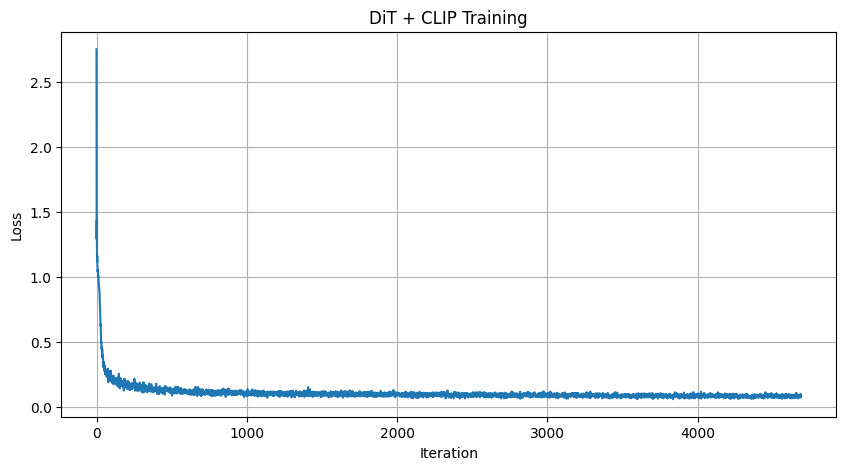

📊 Loss plot saved to: ../outputs/loss_dit_clip.png


In [12]:
# 손실 그래프 생성
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('DiT + CLIP Training')
plt.grid(True)
plt.savefig('../outputs/loss_dit_clip.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Loss plot saved to: ../outputs/loss_dit_clip.png")

In [11]:
checkpoint = torch.load('../checkpoints/dit_clip_mnist_50epochs.pt', map_location=device)
dit.load_state_dict(checkpoint['dit'])
print("✅ Checkpoint loaded successfully!")


✅ Checkpoint loaded successfully!



🎨 Generating samples with trained DiT + CLIP (Text-conditional)...



Sampling with CFG:   0%|          | 0/50 [00:00<?, ?it/s]

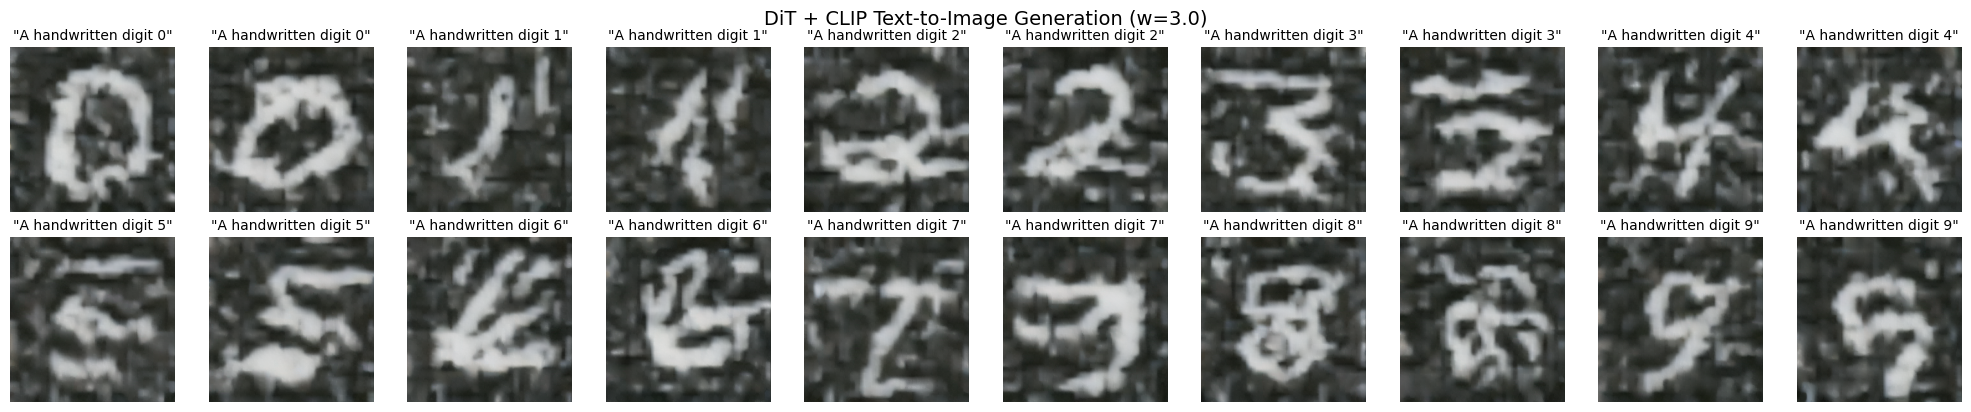


✅ Generated 20 images
   Prompts: 'A handwritten digit 0-9' (2 samples each)
   Resolution: 256×256
   Architecture: DiT + Cross-Attention + CFG
   Guidance scale: 3.0


In [12]:
print("\n🎨 Generating samples with trained DiT + CLIP (Text-conditional)...\n")

def encode_text_for_sampling(prompts, tokenizer, text_encoder, device):
    """Encode text prompts with CLIP"""
    text_tokens = tokenizer(
        prompts,
        padding="max_length",
        max_length=77,
        truncation=True,
        return_tensors="pt"
    ).input_ids.to(device)

    with torch.no_grad():
        text_embs = text_encoder(text_tokens).last_hidden_state

    return text_embs

@torch.no_grad()
def sample_dit_clip(dit, vae, text_encoder, tokenizer, scheduler,
                    text_prompts, guidance_scale=3.0, num_inference_steps=50):
    """
    Sample from DiT + CLIP with CFG

    Args:
        dit: Trained DiT + CLIP model
        vae: VAE decoder
        text_encoder: CLIP text encoder
        tokenizer: CLIP tokenizer
        scheduler: DDPM scheduler
        text_prompts: List of text prompts
        guidance_scale: CFG guidance scale
        num_inference_steps: Number of sampling steps
    """
    dit.eval()
    batch_size = len(text_prompts)

    # Encode text
    text_embs = encode_text_for_sampling(text_prompts, tokenizer, text_encoder, device)
    uncond_embs = encode_text_for_sampling([""] * batch_size, tokenizer, text_encoder, device)

    # Start from random noise
    latents = torch.randn(batch_size, 4, 32, 32).to(device)

    # Set timesteps
    scheduler.set_timesteps(num_inference_steps)

    # Denoising loop with CFG
    for t in tqdm(scheduler.timesteps, desc="Sampling with CFG"):
        # Expand latents for conditional + unconditional
        latents_input = torch.cat([latents, latents], dim=0)
        t_batch = torch.full((batch_size * 2,), t, device=device, dtype=torch.long)
        emb_input = torch.cat([text_embs, uncond_embs], dim=0)

        # Predict noise
        noise_pred = dit(latents_input, t_batch, emb_input)

        # Split and apply CFG
        noise_pred_cond, noise_pred_uncond = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

        # Denoise
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents
    latents = latents / 0.18215
    images = vae.decode(latents).sample

    # Normalize to [0, 1]
    images = (images + 1) / 2
    images = torch.clamp(images, 0, 1)

    return images

# Generate samples for digits 0-9 (2 samples each)
text_prompts = []
for digit in range(10):
    text_prompts.extend([f"A handwritten digit {digit}"] * 2)

samples = sample_dit_clip(
    dit, vae, text_encoder, tokenizer, noise_scheduler,
    text_prompts, guidance_scale=3.0, num_inference_steps=50
)

# Visualize
titles = [f'"{p}"' for p in text_prompts]
plot_images(samples, titles=titles, nrows=2, ncols=10, figsize=(20, 4))
plt.suptitle('DiT + CLIP Text-to-Image Generation (w=3.0)', fontsize=14, y=1.02)
plt.savefig('../outputs/dit_clip_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Generated {len(samples)} images")
print(f"   Prompts: 'A handwritten digit 0-9' (2 samples each)")
print(f"   Resolution: 256×256")
print(f"   Architecture: DiT + Cross-Attention + CFG")
print(f"   Guidance scale: 3.0")


---

# Part 3: Comparison & Analysis

## 📊 DiT Variants

| Variant | Conditioning | AdaLN | Cross-Attn | Use Case |
|---------|-------------|--------|-----------|----------|
| **DiT (Original)** | Class | 6 | ❌ | Classification-guided |
| **DiT + CLIP** | Text | 9 | ✅ | Text-to-image |
| **PixArt** | Text (T5) | 9 | ✅ | High-quality T2I |

---

## 🎯 Key Takeaways

1. **Architecture Simplicity**
   - DiT: Uniform transformer blocks
   - UNet: Complex encoder/decoder
   - Winner: **DiT** (easier to scale)

2. **Scalability**
   - DiT: Add layers/width → better model
   - UNet: Need careful architecture search
   - Winner: **DiT**

3. **Performance**
   - DiT-XL: FID 2.27 on ImageNet
   - ADM (UNet): FID 2.3
   - Winner: **Tie** (but DiT simpler!)

---

## 🚀 Next Steps

- **PixArt**: DiT + T5 (stronger text understanding)
- **SANA**: Linear attention for efficiency

You now understand the **Transformer revolution** in diffusion models! 🎉